In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("line_vs_geodesic.csv")
df.head()

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,dataset_name,diameter,...,line_duration,linear_dist,linear_dist_per_vertex,linear_regression_duration,linear_regression_duration_per_vertex,relative_diff_dist,relative_diff_duration,relative_diff_seq_duration,relative_diff_seq_per_time_and_vertex,run_name
0,run_7lyvlzqm,running,-,ninamiolane,NaN,2023-07-03T20:30:16.000Z,1751,NaN,synthetic,162000,...,0.000400,71456.601764,111.303118,0.000231,3.591133e-07,-1.003566e+07,-3.299169e+06,-2.417674e+06,-753.169364,run_7lyvlzqm
1,run_r3ffn1fr,finished,-,ninamiolane,NaN,2023-07-03T20:23:13.000Z,422,NaN,synthetic,5400,...,0.000351,1104.329724,6.816850,0.000138,8.491822e-07,-4.466106e+04,-6.918306e+05,-8.912364e+05,-550.145906,run_r3ffn1fr
2,run_bngmbqgk,finished,-,ninamiolane,NaN,2023-07-03T20:17:24.000Z,347,NaN,synthetic,5400,...,0.000340,1146.508817,7.077215,0.000160,9.845804e-07,-4.213701e+04,-6.890512e+05,-6.621825e+05,-817.509205,run_bngmbqgk
3,run_3yr30o61,finished,-,ninamiolane,NaN,2023-07-03T20:14:54.000Z,148,NaN,synthetic,180,...,0.000323,22.063001,0.525310,0.000100,2.384186e-06,-1.855326e+02,-2.347706e+05,-3.440078e+05,-819.066265,run_3yr30o61
4,run_xx50xbxp,finished,-,ninamiolane,NaN,2023-07-03T20:13:23.000Z,90,NaN,synthetic,180,...,0.000225,23.245539,0.553465,0.000104,2.480689e-06,-1.746397e+02,-2.365328e+05,-2.301493e+05,-1095.949125,run_xx50xbxp


In [3]:
df.columns

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep',
       'dataset_name', 'diameter', 'n_faces', 'n_steps', 'n_times',
       'n_vertices', 'noise_factor', 'subdivisions', 'diff_dist',
       'diff_dist_per_vertex', 'diff_duration', 'diff_duration_per_vertex',
       'diff_seq_duration', 'diff_seq_duration_per_time_and_vertex',
       'diff_seq_per_time_and_vertex', 'diff_seq_per_time_vertex_diameter',
       'geodesic_dist', 'geodesic_dist_per_vertex', 'geodesic_duration',
       'geodesic_regression_duration',
       'geodesic_regression_duration_per_vertex', 'line_duration',
       'linear_dist', 'linear_dist_per_vertex', 'linear_regression_duration',
       'linear_regression_duration_per_vertex', 'relative_diff_dist',
       'relative_diff_duration', 'relative_diff_seq_duration',
       'relative_diff_seq_per_time_and_vertex', 'run_name'],
      dtype='object')

<Axes: >

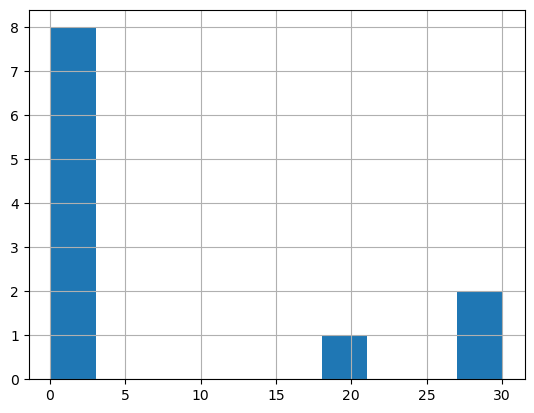

In [5]:
df["diff_seq_per_time_and_vertex"].hist()

<Axes: >

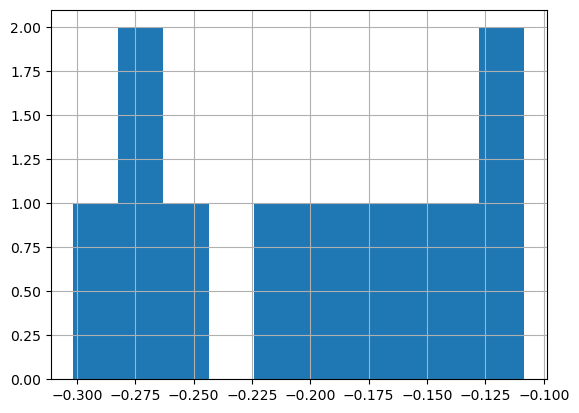

In [4]:
df["diff_seq_duration_per_time_and_vertex"].hist()

In [14]:
import matplotlib.pyplot as plt

def hist_diff_seq_per_time_vertex_diameter_group(by="n_steps"):
    grouped_data = df.groupby(by)["diff_seq_per_time_vertex_diameter"]
    fig, ax = plt.subplots()
    for name, group in grouped_data:
        group.hist(ax=ax, alpha=0.5, label=f"{by} = {name}")
    ax.legend()

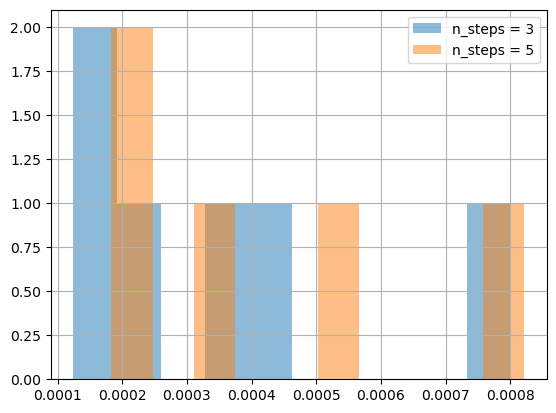

In [15]:
hist_diff_seq_per_time_vertex_diameter_group(by="n_steps")

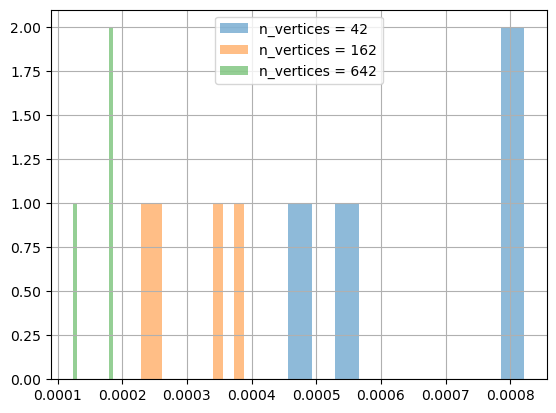

In [16]:
hist_diff_seq_per_time_vertex_diameter_group(by="n_vertices")

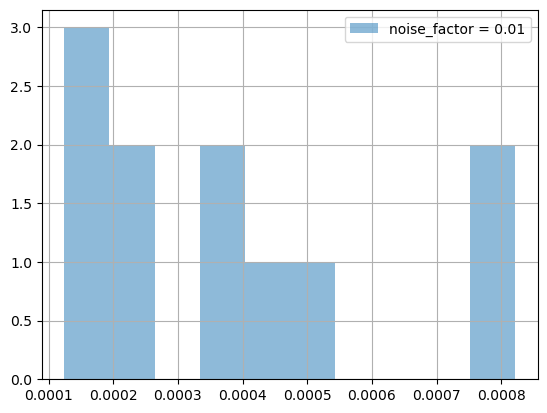

In [17]:
hist_diff_seq_per_time_vertex_diameter_group(by="noise_factor")

In [24]:
import numpy as np

def diff_scatter_grouped(by="n_steps"):
    x = df["diff_seq_per_time_vertex_diameter"]
    y = np.abs(df["diff_duration_per_vertex"])
    color = df[f"{by}"]

    # Create the scatter plot
    plt.scatter(x, y, c=color, cmap="viridis")

    # Set labels and title
    plt.xlabel("diff_seq_per_time_vertex_diameter")
    plt.ylabel("diff_duration_per_vertex")
    plt.title("Scatter Plot of diff_seq_per_time_vertex_diameter vs diff_duration_per_vertex")

    # Add colorbar
    cbar = plt.colorbar()
    cbar.set_label(f"{by}")

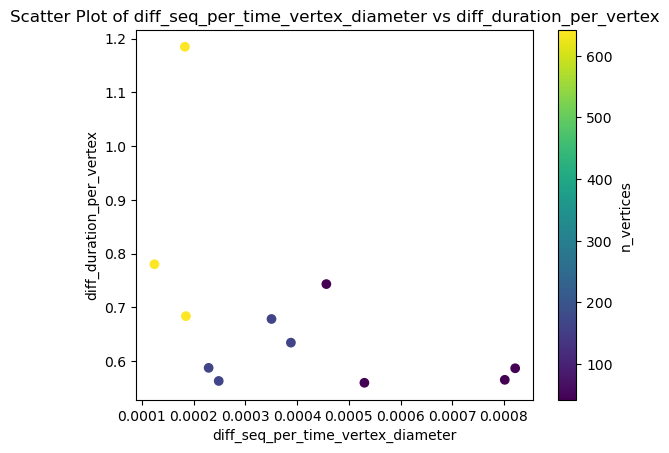

In [25]:
diff_scatter_grouped(by="n_vertices")

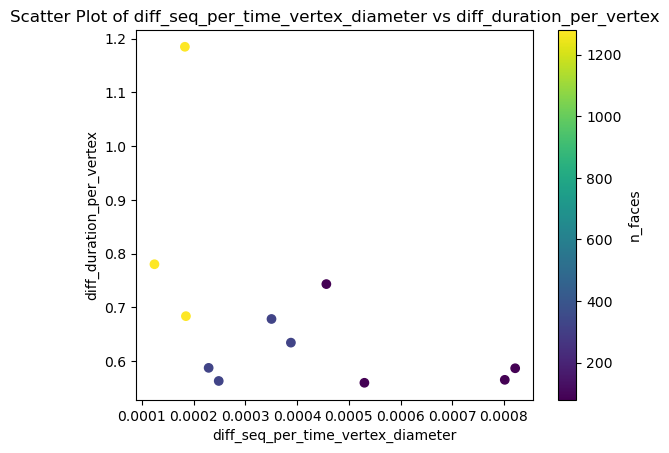

In [26]:
diff_scatter_grouped(by="n_faces")

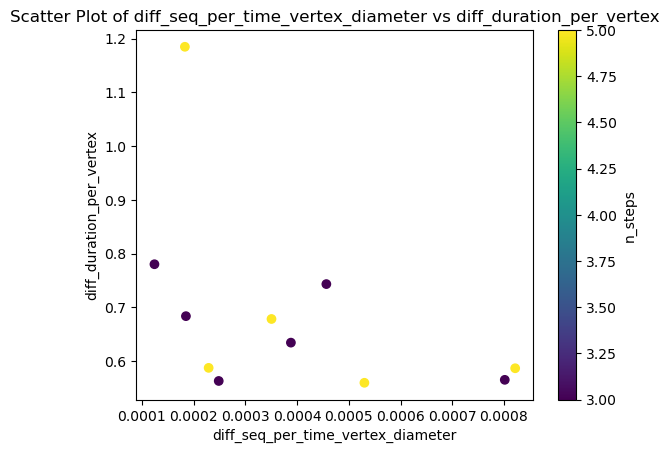

In [27]:
diff_scatter_grouped(by="n_steps")